# Import, classes, functions...

## Librairie Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import SilhouetteVisualizer

import missingno as msno

import pickle

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

## Classes

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### PCA

In [3]:
class c_PCA :
    def __init__(self, df, columns, n_components=6):
        """
        Initialize the PCAAnalysis object.

        Args:
            df (pandas.DataFrame): The input DataFrame.
            columns (list): List of columns to be used for PCA analysis.
            n_components (int): Number of principal components to keep.

        Returns:
            None
        """
        self.df = df[columns]
        self.columns = columns
        self.n_components = n_components
        self.X = self.df.values 
        self.X_scaled = None
        self.X_scaled_verif = None
        self.pca = None
        self.pcs = None
    
    def scale(self, scaler_type):
        """
        Scale the features using the specified scaler.

        Args:
            scaler_type (object): The scaler object to use for scaling.

        Returns:
            None
        """
        scaler = scaler_type
        scaled_features = scaler.fit(self.X)
        self.X_scaled = scaled_features.transform(self.X)
        self.X_scaled_verif = pd.DataFrame(self.X_scaled).describe().round(2).loc[["mean", "std"], :]
        

    def pca_evr(self):
        """
        Perform PCA analysis and calculate the explained variance ratio.

        Returns:
            None
        """
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(self.X_scaled)
        
        self.pcs = self.pca.components_
        self.pcs = pd.DataFrame(self.pcs, columns=self.columns)
        self.pcs.index = [f"F{i+1}" for i in range(self.n_components)]
        self.pcs = self.pcs.round(2)
        
        evr = (self.pca.explained_variance_ratio_*100).round(2)
        print("Explained variance ratio:", evr)
        evr_cum = evr.cumsum().round()
        print("Cumulative explained variance ratio:", evr_cum)
        
        x_list = range(1, self.n_components+1)
        
        plt.bar(x_list, evr)
        plt.plot(x_list, evr_cum, c="red", marker='o')
        plt.xlabel("Rank of principal component")
        plt.ylabel("Percentage of explained variance")
        plt.title("Scree Plot")
        plt.show(block=False)
        
    def correlation_circle(self, ax, x_y):
        """
        Plot a correlation circle.

        Parameters:
        - ax (matplotlib.axes.Axes): The axes to plot on.
        - x_y (tuple): Tuple containing the x and y indices.

        Returns:
        - None
        """

        x, y = x_y

        for i in range(0, self.pca.components_.shape[1]):
            ax.arrow(0, 0,
                     self.pca.components_[x, i],
                     self.pca.components_[y, i],
                     head_width=0.07,
                     head_length=0.07,
                     width=0.02)

            plt.text(self.pca.components_[x, i] + 0.05,
                     self.pca.components_[y, i] + 0.05,
                     self.columns[i])

        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        plt.xlabel('F{} ({}%)'.format(x+1, round(100*self.pca.explained_variance_ratio_[x], 1)))
        plt.ylabel('F{} ({}%)'.format(y+1, round(100*self.pca.explained_variance_ratio_[y], 1)))

        plt.title("Correlation circle (F{} et F{})".format(x+1, y+1))

        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))

        # Set equal aspect ratio for the plot
        plt.axis('equal')
        plt.show(block=False) 
        
    def display_factorial_planesi(self, ax, x_y,
                                  labels=None,
                                  clusters=None,
                                  alpha=1,
                                  marker="."):
        """
        Display factorial planes.

        Parameters:
        - ax (matplotlib.axes.Axes): The axes to plot on.
        - x_y (tuple): Tuple containing the x and y indices.
        - labels (list, optional): List of labels for the points. Default is None.
        - clusters (array-like, optional): Array-like object representing the cluster labels. Default is None.
        - alpha (float, optional): Alpha value for the points. Default is 1.
        - marker (str, optional): Marker style for the points. Default is ".".

        Returns:
        - None
        """

        X_projected = self.pca.transform(self.X_scaled)
        X_ = np.array(X_projected)

        if labels is None:
            labels = []
        
        if not isinstance(labels, list):
            raise ValueError("labels must be a list")

        if len(x_y) != 2:
            raise AttributeError("2 axes are required")
        
        if max(x_y) >= X_.shape[1]:
            raise AttributeError("Invalid axis variable")

        x, y = x_y

        c = None if clusters is None else clusters

        sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())

        v1 = str(round(100 * self.pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * self.pca.explained_variance_ratio_[y])) + " %"

        ax.set_xlabel(f'F{x + 1} {v1}')
        ax.set_ylabel(f'F{y + 1} {v2}')

        x_max = np.abs(X_[:, x]).max() * 1.1
        y_max = np.abs(X_[:, y]).max() * 1.1

        ax.set_xlim(left=-x_max, right=x_max)
        ax.set_ylim(bottom=-y_max, top=y_max)

        plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
        plt.plot([0, 0], [-y_max, y_max], color='grey', alpha=0.8)

        if len(labels):
            for i, (_x, _y) in enumerate(X_[:, [x, y]]):
                plt.text(_x, _y + 0.05, labels[i], fontsize='14', ha='center', va='center')

        plt.title(f"Projection des individus (sur F{x + 1} et F{y + 1})")
        plt.show()

### CAH

In [4]:
class CAH :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.Z = None
        self.df_mean_std = None
        self.clusters = None
    
    def scale(self,scalertype : StandardScaler)->None:
        """
        This function scales the data using the scaler type provided as input. 
        We are also creating a short DataFrame with the mean and standard deviation of the scaled data.
        
        Parameters:
            scalertype (StandardScaler) : scaler type to use for scaling the data
        
        Returns:
            None
        """
        #Put values in the scaler, fit and transform
        X = self.df.values
        scaler = scalertype
        scaled_features = scaler.fit(X)
        X_scaled = scaled_features.transform(X)
        #Linkage using ward method
        self.Z = linkage(X_scaled, method='ward')
        # Short DataFrame with mean and std to verify the scaling
        self.df_mean_std = pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]
        
    def dendrogram(self,ax,title='Dendogram',xlabel='Distance',ylabel='Individus',labelsize=5):
        '''This function plots the dendrogram. Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, xlabel, ylabel, labelsize
        '''
        _ = dendrogram(self.Z, ax=ax, labels=self.df.index, orientation = "left")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', which='major', labelsize=labelsize)
        ax.tick_params(axis='y', which='major', labelsize=labelsize)
        
    def cluster(self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the dendogram.
            input: n_clusters
        '''
        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage = "ward")
        clustering_model.fit(self.df.values)
        self.clusters = clustering_model.labels_

### Kmeans

In [5]:
class kmeans :
    """
    Class for performing K-means clustering and visualizing the results.
    """

    def __init__(self, df, columns):
        """
        Initialize KMeansClustering object.

        Parameters:
        - df (pandas DataFrame): Input data.
        - columns (list): List of column names to use for clustering.
        """
        self.df = df[columns]
        self.columns = columns
        self.clusters = []

    def plot_inertia(self, ax, title="Inertia", k_max=10):
        """
        Plot the inertia of K-means clustering for different values of k.

        Parameters:
        - ax (matplotlib axes): Axes object to plot on.
        - title (str): Title of the plot (default: "Inertia").
        - k_max (int): Maximum number of clusters to consider (default: 10).
        """
        inertia_list = []
        X = self.df.values
        for k in range(1, k_max):
            kmeans = KMeans(n_clusters=k, n_init='auto')
            kmeans.fit(X)
            inertia_list.append(kmeans.inertia_)
        ax.set_title(title)
        ax.set_xlabel("n_clusters")
        ax.set_ylabel("inertia")
        ax.plot(range(1, k_max), inertia_list)

    def plot_silhouette(self, ax, k_list):
        """
        Plot the silhouette scores of K-means clustering for different values of k.

        Parameters:
        - ax (matplotlib axes): Axes object to plot on.
        - k_list (list): List of k values to consider.
        """
        X = self.df.values
        for k in k_list:
            if k < 2:
                print("k must be greater than 1")
            else:
                ax[k-2].set_title("Silhouette plot for k = {}".format(k))
                kmeans = KMeans(n_clusters=k, n_init='auto')
                kmeans.fit(X)
                score = silhouette_score(self.df.values, kmeans.labels_)
                print("For n_clusters = {}, silhouette score is {:.3f})".format(k, score))
                visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[k-2])
                visualizer.fit(X)

    def kmean_choose(self, n_clusters):
        """
        Perform K-means clustering and store the cluster labels.

        Args:
            n_clusters (int): Number of clusters to create.

        Returns:
            None
        """

        # Get the feature values as input for K-means clustering
        X = self.df.values

        # Initialize and fit the K-means model
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
        kmeans.fit(X)

        # Store the cluster labels in the object's attribute
        self.clusters = kmeans.labels_
    
    def kmean_predict(self, n_clusters, feature_to_predict, X_train, X_test, y_train, y_test, random_state=42):
        """
        Perform K-means clustering and predict the target feature.

        Args:
            n_clusters (int): Number of clusters to create.
            feature_to_predict (str): Name of the target feature to predict.
            test_size (float): Proportion of the dataset to use as test data.
            random_state (int): Seed for random number generator.

        Returns:
            None
        """

        # Split the data into features (X) and target (y)
        y = self.df[feature_to_predict].values
        X = self.df.drop(columns=feature_to_predict, axis=1).values

        # Initialize and fit the K-means model
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=random_state)
        kmeans.fit(X_train)

        # Predict the clusters for the test data
        y_pred = kmeans.predict(X_test)

        # Calculate and print the accuracy score
        print("Accuracy score:", accuracy_score(y_test, y_pred))

        # Print the confusion matrix
        print("Confusion matrix:")
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show(block=False)

# Import

In [6]:
df = pd.read_csv('billets.csv', sep=";")

In [7]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


# Data Exploration

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


<Axes: >

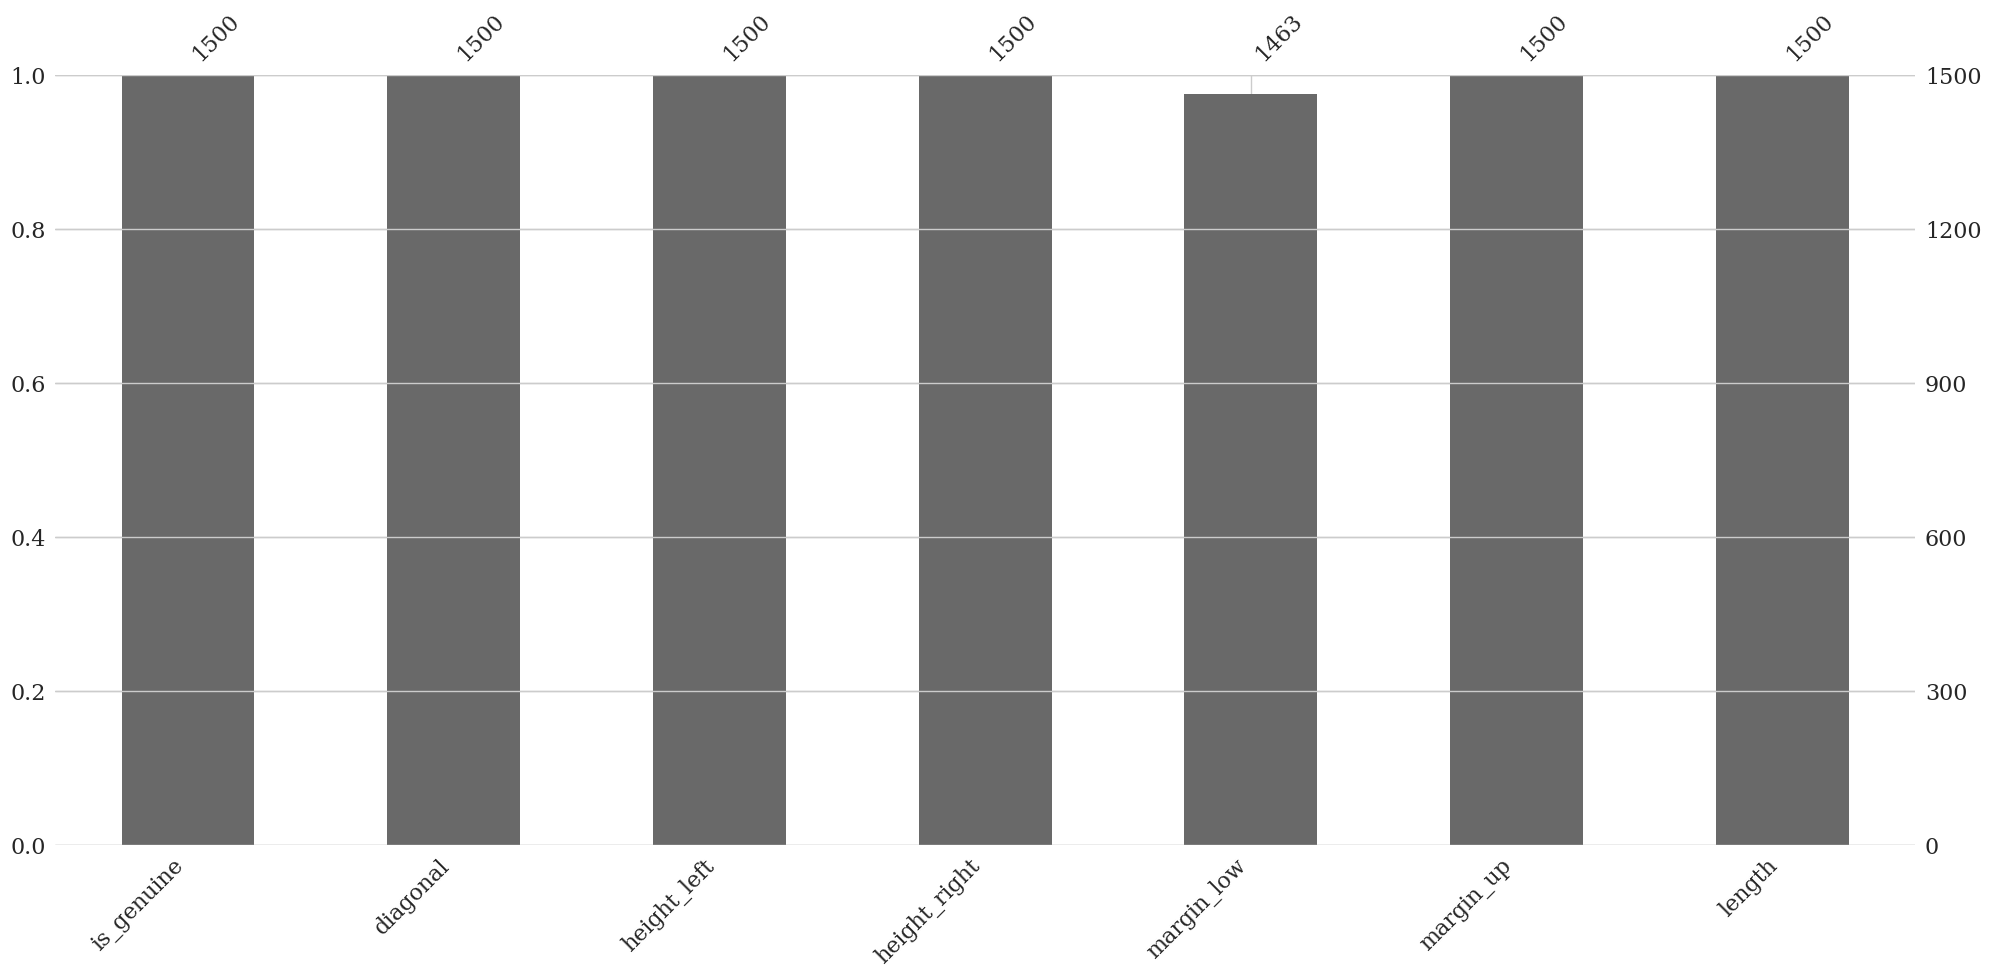

In [10]:
msno.bar(df)

We got missing data in margin_low. We will need to fill it.

Now, we will first split the dataset into two parts: one with genuine banknotes and one with forged banknotes. This will allow us to see if there is a difference between the two groups.

In [11]:
df_isgenuine = df[df['is_genuine'] == True]
df_isnotgenuine = df[df['is_genuine'] == False]
df_isgenuine = df_isgenuine.drop(['is_genuine'], axis=1)
df_isnotgenuine = df_isnotgenuine.drop(['is_genuine'], axis=1)

In [12]:
df_isgenuine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1000 non-null   float64
 1   height_left   1000 non-null   float64
 2   height_right  1000 non-null   float64
 3   margin_low    971 non-null    float64
 4   margin_up     1000 non-null   float64
 5   length        1000 non-null   float64
dtypes: float64(6)
memory usage: 54.7 KB


In [13]:
df_isnotgenuine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 1000 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      500 non-null    float64
 1   height_left   500 non-null    float64
 2   height_right  500 non-null    float64
 3   margin_low    492 non-null    float64
 4   margin_up     500 non-null    float64
 5   length        500 non-null    float64
dtypes: float64(6)
memory usage: 27.3 KB


## Histplot

This code snippet performs the Shapiro-Wilk test for normality on each column of a DataFrame df. It prints the results of the test, indicating whether the data in each column is normally distributed or not. If the p-value of the test is greater than 0.05, it suggests that the data is probably Gaussian (normally distributed). Otherwise, it indicates that the null hypothesis (the data is normally distributed) is rejected.

In [14]:
def shapiro_test(df,col):
    #shapiro test for each column
    print(color.BOLD + 'Shapiro test for each column' + color.END)
    print('-----------------------------')
    print('H0: the data is normally distributed')
    print('H1: the data is not normally distributed')
    print('α = 5%')
    print('-----------------------------')
    print()
    for feature in col:
        print(color.UNDERLINE + color.BLUE + feature + color.END)
        stat, p = stats.shapiro(df[feature])
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print(color.GREEN + 'Probably Gaussian' + color.END)
        else:
            print(color.RED + 'H0 rejected' + color.END)
        print()

## Genuine

Text(0.5, 0.98, 'Histograms of genuine banknotes')

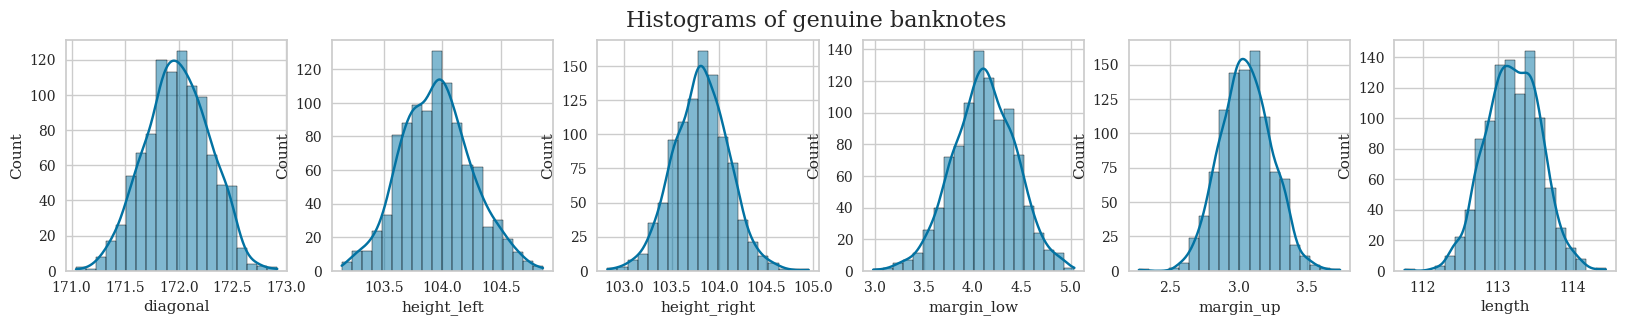

In [15]:
fig, ax = plt.subplots(1,6,figsize=(20, 3))
sns.histplot(data=df_isgenuine, x="diagonal", kde="True", ax=ax[0], bins=20)
sns.histplot(data=df_isgenuine, x="height_left", kde="True", ax=ax[1], bins=20)
sns.histplot(data=df_isgenuine, x="height_right", kde="True", ax=ax[2], bins=20)
sns.histplot(data=df_isgenuine, x="margin_low", kde="True", ax=ax[3], bins=20)
sns.histplot(data=df_isgenuine, x="margin_up", kde="True", ax=ax[4], bins=20)
sns.histplot(data=df_isgenuine, x="length", kde="True", ax=ax[5], bins=20)
fig.suptitle('Histograms of genuine banknotes', fontsize=16)

In [16]:
shapiro_test(df_isgenuine, df_isgenuine.columns.tolist())

Shapiro test for each column
-----------------------------
H0: the data is normally distributed
H1: the data is not normally distributed
α = 5%
-----------------------------

diagonal
Statistics=0.998, p=0.310
Probably Gaussian

height_left
Statistics=0.997, p=0.029
H0 rejected

height_right
Statistics=0.999, p=0.587
Probably Gaussian

margin_low
Statistics=nan, p=1.000
Probably Gaussian

margin_up
Statistics=0.998, p=0.355
Probably Gaussian

length
Statistics=0.998, p=0.304
Probably Gaussian



The data all seem to follow a normal law, except for *height_left*

In [17]:
for col in df_isgenuine.columns.tolist():
    print(color.BOLD + col + color.END)
    print('Skewness: {:.2f}'.format(skew(df_isgenuine[col])))
    print('Kurtosis: {:.2f}'.format(kurtosis(df_isgenuine[col])))
    print()

diagonal
Skewness: -0.04
Kurtosis: -0.27

height_left
Skewness: 0.15
Kurtosis: -0.12

height_right
Skewness: -0.01
Kurtosis: 0.27

margin_low
Skewness: nan
Kurtosis: nan

margin_up
Skewness: 0.04
Kurtosis: 0.12

length
Skewness: -0.05
Kurtosis: -0.01



Text(0.5, 0.98, 'Histograms of forged banknotes')

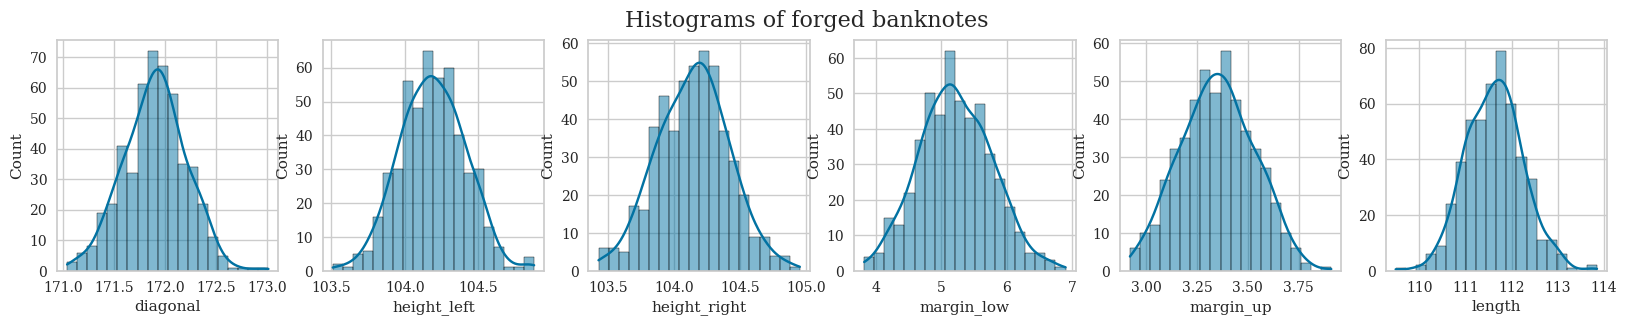

In [18]:
fig, ax = plt.subplots(1,6,figsize=(20, 3))
sns.histplot(data=df_isnotgenuine, x="diagonal", kde="True", ax=ax[0], bins=20)
sns.histplot(data=df_isnotgenuine, x="height_left", kde="True", ax=ax[1], bins=20)
sns.histplot(data=df_isnotgenuine, x="height_right", kde="True", ax=ax[2], bins=20)
sns.histplot(data=df_isnotgenuine, x="margin_low", kde="True", ax=ax[3], bins=20)
sns.histplot(data=df_isnotgenuine, x="margin_up", kde="True", ax=ax[4], bins=20)
sns.histplot(data=df_isnotgenuine, x="length", kde="True", ax=ax[5], bins=20)
fig.suptitle('Histograms of forged banknotes', fontsize=16)

In [19]:
shapiro_test(df_isnotgenuine, df_isnotgenuine.columns.tolist())

Shapiro test for each column
-----------------------------
H0: the data is normally distributed
H1: the data is not normally distributed
α = 5%
-----------------------------

diagonal
Statistics=0.997, p=0.639
Probably Gaussian

height_left
Statistics=0.998, p=0.791
Probably Gaussian

height_right
Statistics=0.998, p=0.827
Probably Gaussian

margin_low
Statistics=nan, p=1.000
Probably Gaussian

margin_up
Statistics=0.996, p=0.193
Probably Gaussian

length
Statistics=0.997, p=0.527
Probably Gaussian



For forged bankanotes, all features seem to follow a normal law.

In [20]:
for col in df_isnotgenuine.columns.tolist():
    print(color.BOLD + col + color.END)
    print('Skewness: {:.2f}'.format(skew(df_isnotgenuine[col])))
    print('Kurtosis: {:.2f}'.format(kurtosis(df_isnotgenuine[col])))
    print()

diagonal
Skewness: 0.01
Kurtosis: 0.14

height_left
Skewness: 0.06
Kurtosis: 0.02

height_right
Skewness: -0.01
Kurtosis: -0.11

margin_low
Skewness: nan
Kurtosis: nan

margin_up
Skewness: 0.05
Kurtosis: -0.41

length
Skewness: 0.11
Kurtosis: 0.28



## Corrélation

<Axes: >

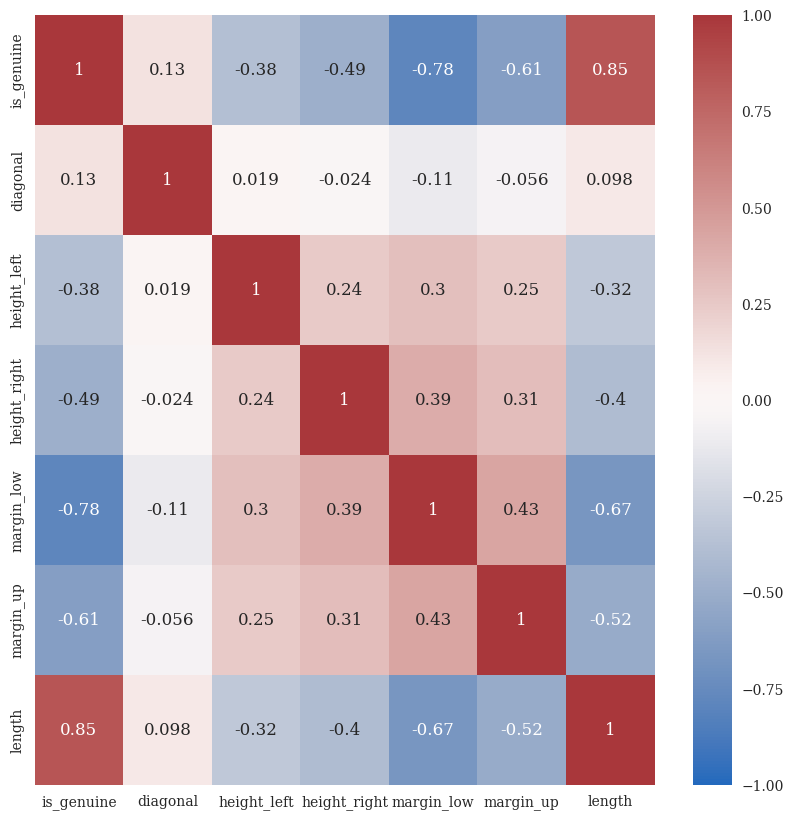

In [21]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap="vlag", vmin=-1, vmax=1, annot=True)

The correlation heatmap provided shows the correlation coefficients between different variables in the dataset. Here are a few observations:

- The column 'is_genuine' (indicating whether a banknote is genuine or not) has a positive correlation of 1.0 with itself, as expected.

- The other variables ('diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length') show varying degrees of correlation with 'is_genuine'.

- The variable 'length' has the highest positive correlation of 0.849285 with 'is_genuine', indicating a relatively strong positive relationship.

- 'height_left' and 'height_right' have negative correlations with 'is_genuine', suggesting an inverse relationship.

- 'margin_low' and 'margin_up' also have negative correlations with 'is_genuine', indicating a negative relationship.

- The magnitude of the correlation coefficients ranges from -1 to 1, with values closer to -1 or 1 indicating a stronger relationship, while values close to 0 suggest a weaker or no linear relationship.

It's important to note that correlation coefficients only measure linear relationships between variables and do not imply causation.

## BoxPlot

Text(0.5, 0.98, 'BoxPlot of genuine and forged banknotes')

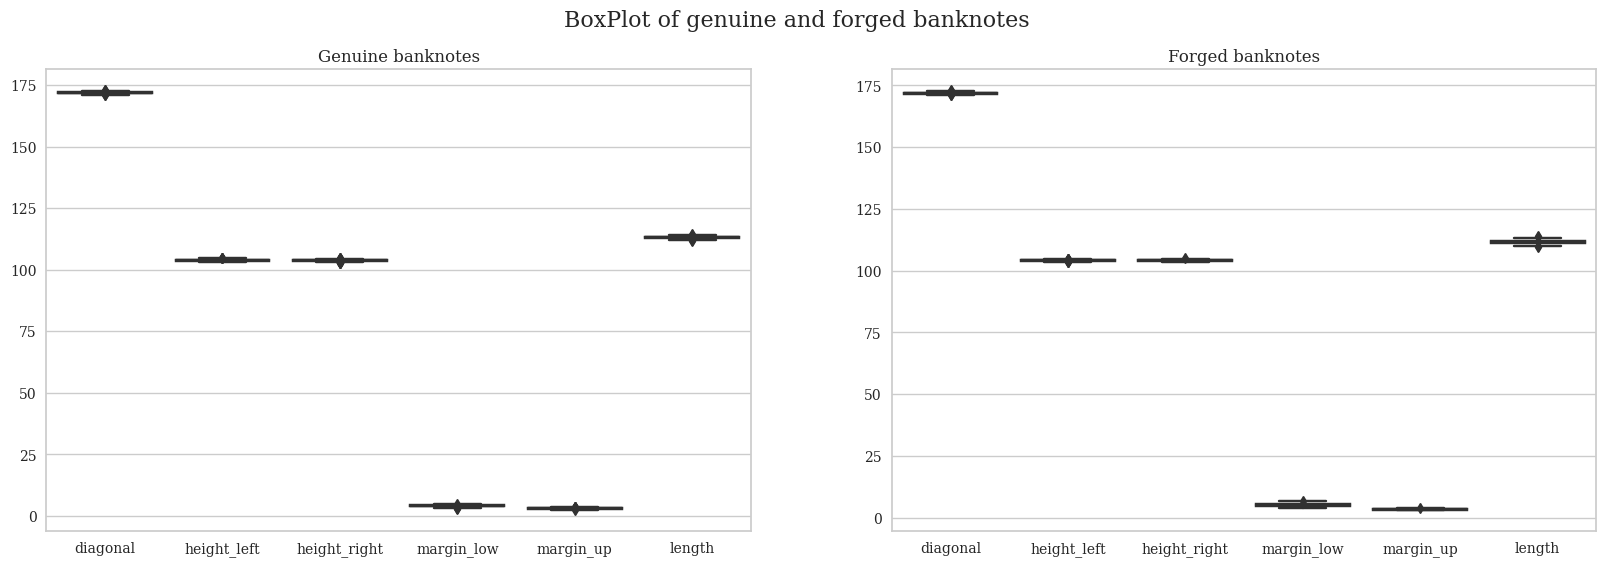

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20, 6))
sns.boxplot(data=df_isgenuine, ax=ax[0])
ax[0].set_title("Genuine banknotes")
sns.boxplot(data=df_isnotgenuine, ax=ax[1])
ax[1].set_title("Forged banknotes")
fig.suptitle("BoxPlot of genuine and forged banknotes", fontsize=16)

The two datasets looks very similar. However, we can see the lenght feature is a bit different.

## ScatterPlot

Text(0.5, 0.98, 'ScatterPlot between margin_low and other features for all banknotes')

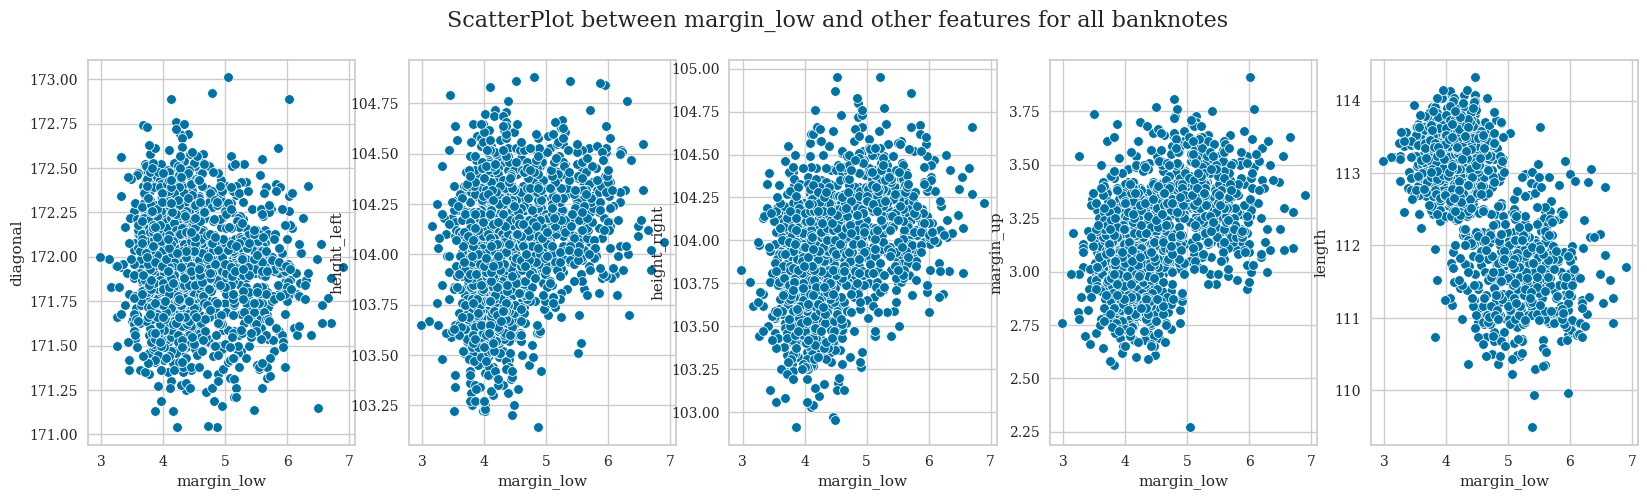

In [23]:
fig, ax = plt.subplots(1,5,figsize=(20, 5))
sns.scatterplot(data=df, x="margin_low", y="diagonal", ax=ax[0])
sns.scatterplot(data=df, x="margin_low", y="height_left", ax=ax[1])
sns.scatterplot(data=df, x="margin_low", y="height_right", ax=ax[2])
sns.scatterplot(data=df, x="margin_low", y="margin_up", ax=ax[3])
sns.scatterplot(data=df, x="margin_low", y="length", ax=ax[4])
fig.suptitle("ScatterPlot between margin_low and other features for all banknotes", fontsize=16)

Text(0.5, 0.98, 'ScatterPlot between margin_low and other features for genuine banknotes')

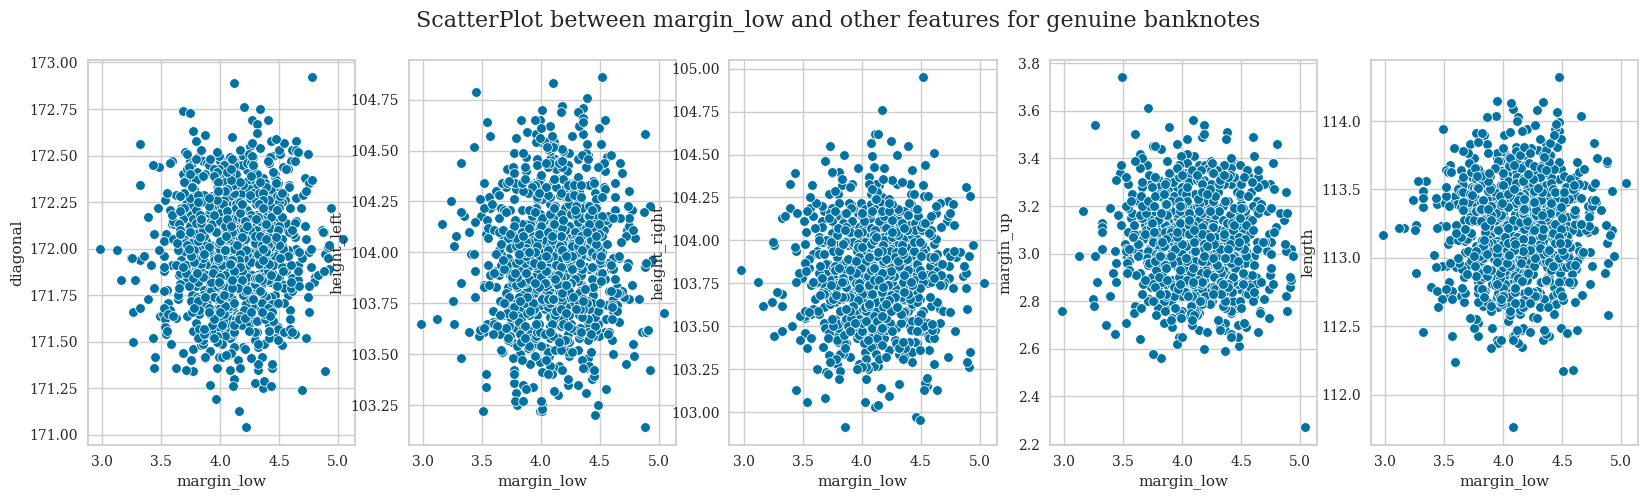

In [24]:
fig, ax = plt.subplots(1,5,figsize=(20, 5))
sns.scatterplot(data=df_isgenuine, x="margin_low", y="diagonal", ax=ax[0])
sns.scatterplot(data=df_isgenuine, x="margin_low", y="height_left", ax=ax[1])
sns.scatterplot(data=df_isgenuine, x="margin_low", y="height_right", ax=ax[2])
sns.scatterplot(data=df_isgenuine, x="margin_low", y="margin_up", ax=ax[3])
sns.scatterplot(data=df_isgenuine, x="margin_low", y="length", ax=ax[4])
fig.suptitle("ScatterPlot between margin_low and other features for genuine banknotes", fontsize=16)

Text(0.5, 0.98, 'ScatterPlot between margin_low and other features for forged banknotes')

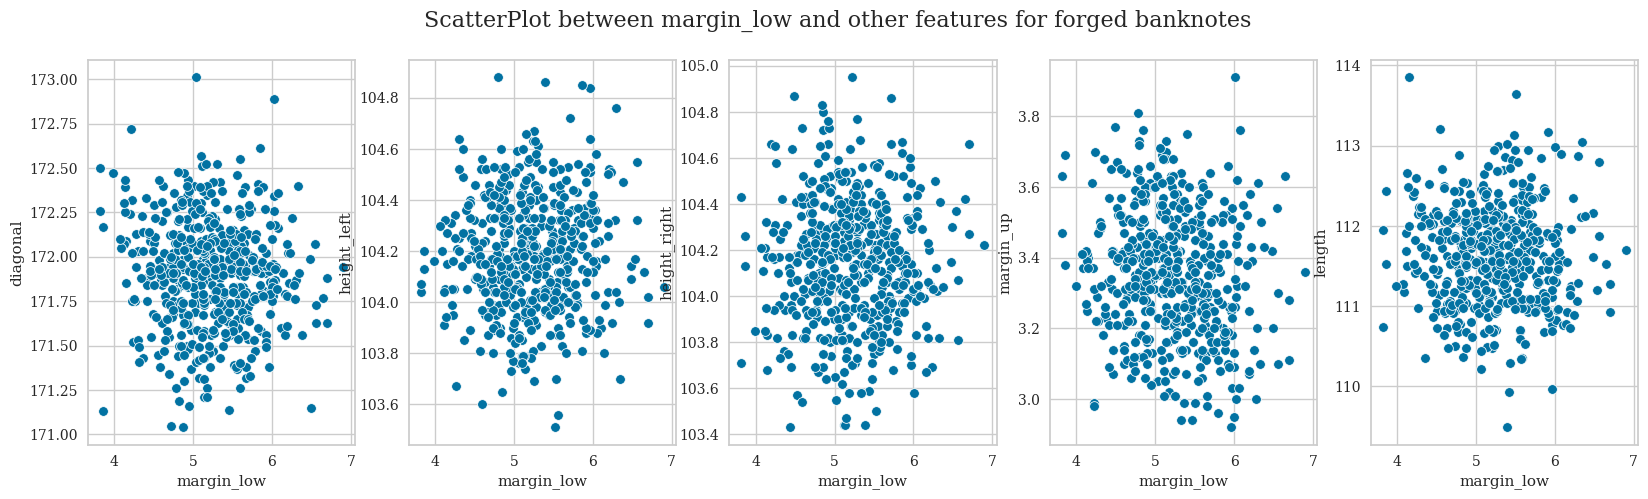

In [25]:
fig, ax = plt.subplots(1,5,figsize=(20, 5))
sns.scatterplot(data=df_isnotgenuine, x="margin_low", y="diagonal", ax=ax[0])
sns.scatterplot(data=df_isnotgenuine, x="margin_low", y="height_left", ax=ax[1])
sns.scatterplot(data=df_isnotgenuine, x="margin_low", y="height_right", ax=ax[2])
sns.scatterplot(data=df_isnotgenuine, x="margin_low", y="margin_up", ax=ax[3])
sns.scatterplot(data=df_isnotgenuine, x="margin_low", y="length", ax=ax[4])
fig.suptitle("ScatterPlot between margin_low and other features for forged banknotes", fontsize=16)

# Predict missing values

First of all, we will split our datas between missings values and goods values. Then, we will train our model on the goods values and predict the missings values.

In [26]:
df_good = df.dropna()
df_missing = df[df['margin_low'].isna()]

In [27]:
df_good.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


In [28]:
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     bool   
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    0 non-null      float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: bool(1), float64(6)
memory usage: 2.1 KB


## Linear Regression

This function performs linear regression analysis on the given input data. It splits the data into training and testing sets using the train_test_split function, with the option to stratify the data based on a specified stratifier. The function fits a linear regression model to the training data using LinearRegression(). The model is then used to predict the target variable for the test data.


The function calculates and prints the R-squared score, mean squared error (MSE), and adjusted R-squared score as evaluation metrics for the regression model.

The trained linear regression model is returned as the output of the function.

In [29]:
def linear_regression(X, y, stratifier, test_size=0.3):
    """
    Perform linear regression analysis on the given input data.
    
    Parameters:
    X (array-like): The input features.
    y (array-like): The target variable.
    stratifier (array-like): The stratifier for splitting the data.
    test_size (float, optional): The proportion of the data to use for testing. Defaults to 0.3.

    Returns:
    obj: The trained linear regression model.
    """
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=stratifier, random_state=42)
    reg = LinearRegression().fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    print("R2 score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))

    # Calculate adjusted R2
    n = len(y_test)
    p = len(X_test.columns)
    adj_r2 = 1 - ((1 - r2_score(y_test, y_pred)) * (n - 1) / (n - p - 1))
    print("Adjusted R2 score:", adj_r2)
    return reg

In [30]:
stratifier = df_good['is_genuine']
X = df_good.drop(['is_genuine','margin_low'], axis=1)
y = df_good['margin_low']
# Launch linear regression with multiple test size
for i in range(1,10):
    print(color.BOLD + 'Test size: ' + str(i/10) + color.END)
    linear_regression(X, y, stratifier, i/10)
    print()

Test size: 0.1
R2 score: 0.5189717539480123
MSE: 0.18599126202484775
Adjusted R2 score: 0.5019140147263106

Test size: 0.2
R2 score: 0.5015485473599904
MSE: 0.2303374337167526
Adjusted R2 score: 0.49286472414326554

Test size: 0.3
R2 score: 0.4860788661658719
MSE: 0.2339008298288792
Adjusted R2 score: 0.4801444419876487

Test size: 0.4
R2 score: 0.5016027523150144
MSE: 0.22452030682308835
Adjusted R2 score: 0.49730622431773

Test size: 0.5
R2 score: 0.5048513487861686
MSE: 0.22822272269119556
Adjusted R2 score: 0.5014412341083874

Test size: 0.6
R2 score: 0.49502092110508744
MSE: 0.22836028125235722
Adjusted R2 score: 0.49212539886371753

Test size: 0.7
R2 score: 0.48499170981504314
MSE: 0.23338291343335835
Adjusted R2 score: 0.4824646818946067

Test size: 0.8
R2 score: 0.4755679443549623
MSE: 0.2371363494991872
Adjusted R2 score: 0.4733171630002626

Test size: 0.9
R2 score: 0.46688181858795663
MSE: 0.23828545414536928
Adjusted R2 score: 0.4648485684681548



0,2 seems to be the best test size to train our model.

In [31]:
reg = linear_regression(X, y, stratifier, 0.2)

R2 score: 0.5015485473599904
MSE: 0.2303374337167526
Adjusted R2 score: 0.49286472414326554


## Prediction

In [32]:
X_pred = df_missing.drop(['is_genuine','margin_low'], axis=1)
y_pred = reg.predict(X_pred)
y_pred

array([4.32562063, 4.40129789, 4.41829353, 4.33594618, 4.64892914,
       3.810989  , 4.19148227, 4.13665018, 4.14664191, 4.17159969,
       4.17951271, 3.77859564, 4.06901992, 4.30727144, 4.15982535,
       4.09170267, 4.44353623, 4.47466625, 4.35193793, 4.09366392,
       3.63100102, 4.37700006, 4.10036433, 4.25278135, 3.90573264,
       3.74993254, 4.2426492 , 4.71809143, 4.14323543, 5.04629451,
       4.79894731, 5.05632538, 5.03397818, 4.78538484, 5.71664953,
       5.19167256, 5.13535633])

In [33]:
y_pred_linear_reg = y_pred

In [34]:
df_missing['margin_low'] = y_pred
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     bool   
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    37 non-null     float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: bool(1), float64(6)
memory usage: 2.1 KB


/tmp/ipykernel_150344/2635995344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_missing['margin_low'] = y_pred


We have predicted the values ! Now, we can merge back our two dataframes

In [35]:
df = df_good.merge(df_missing, how='outer')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


# PCA, CAH

## PCA

Explained variance ratio: [49.25 14.57 11.28 10.23  8.45  4.62]
Cumulative explained variance ratio: [49. 64. 75. 85. 94. 98.]


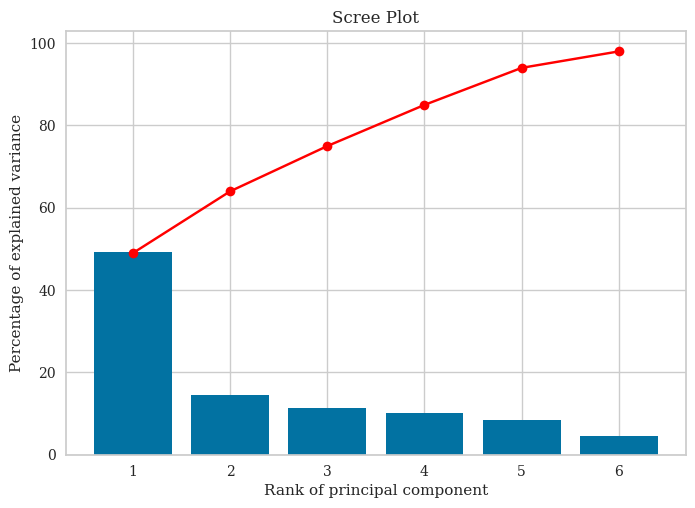

In [36]:
pca = c_PCA(df, df.columns,6)
pca.scale(StandardScaler())
pca.pca_evr()

### Correlations circles

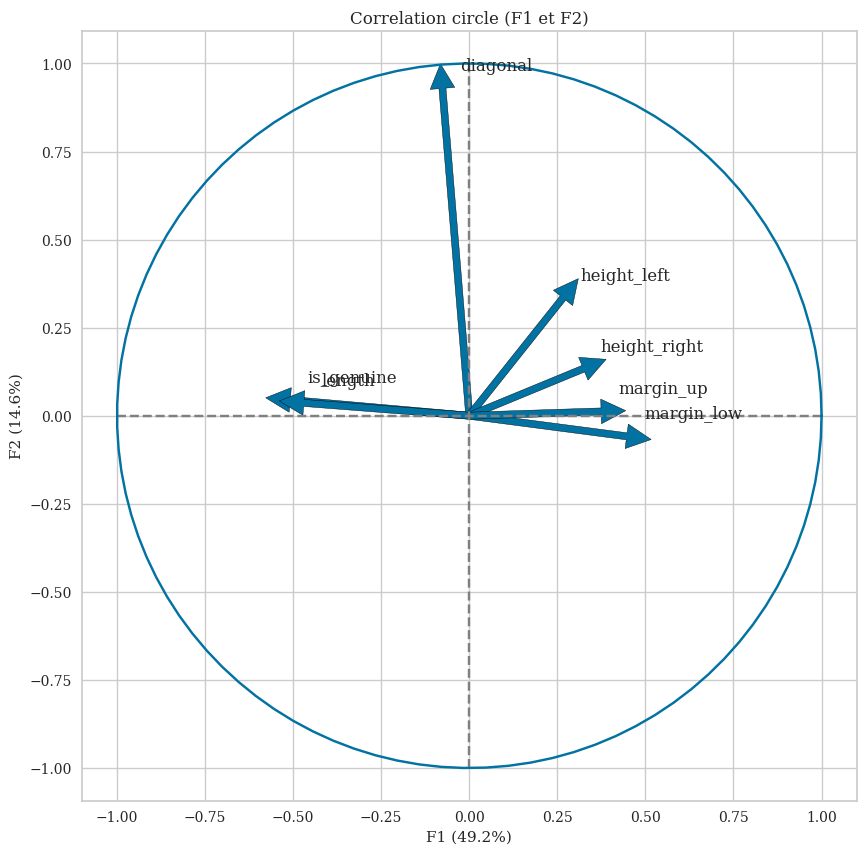

In [37]:
corr1, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,1))

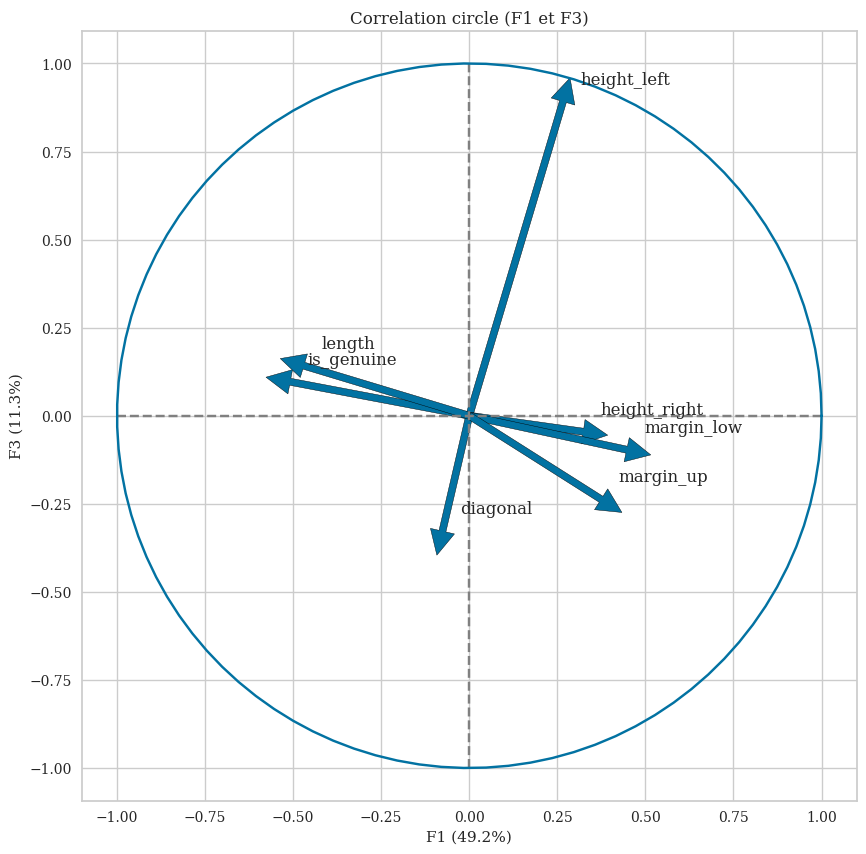

In [38]:
corr2, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,2))

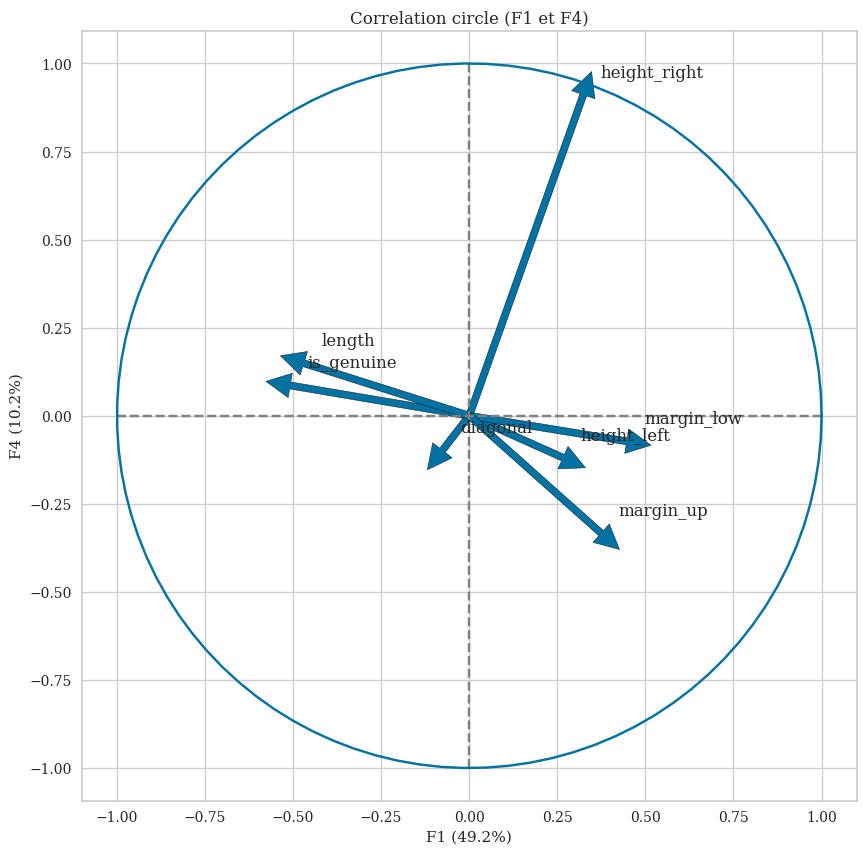

In [39]:
corr3, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,3))

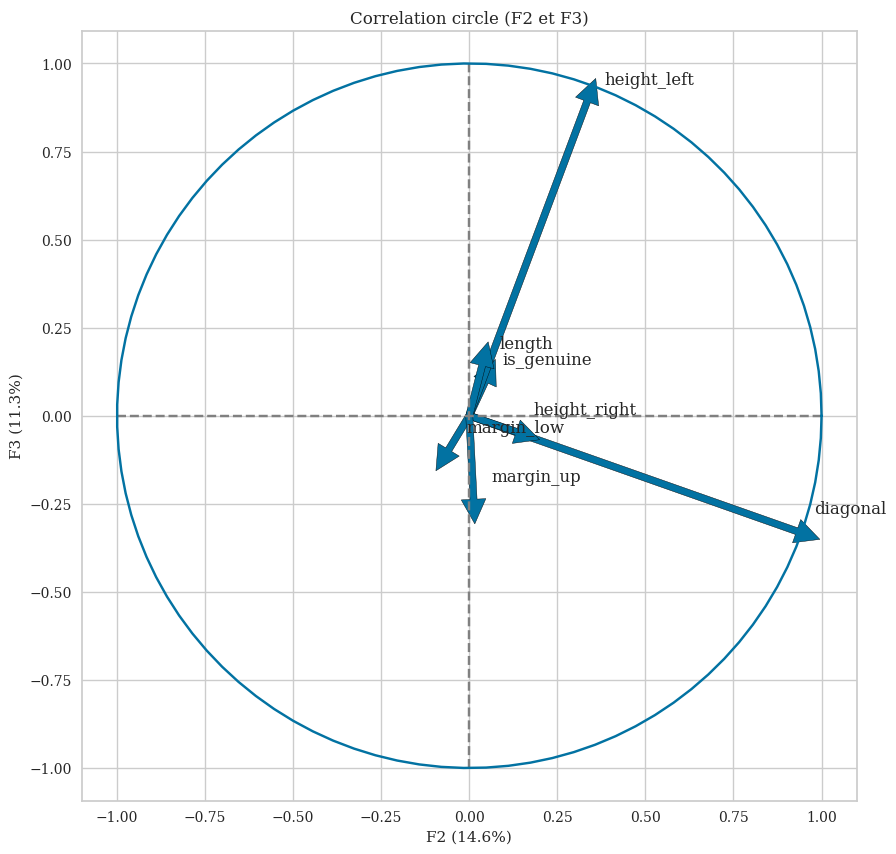

In [40]:
corr4, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (1,2))

### Factorial Planes

/tmp/ipykernel_150344/963579061.py:148: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


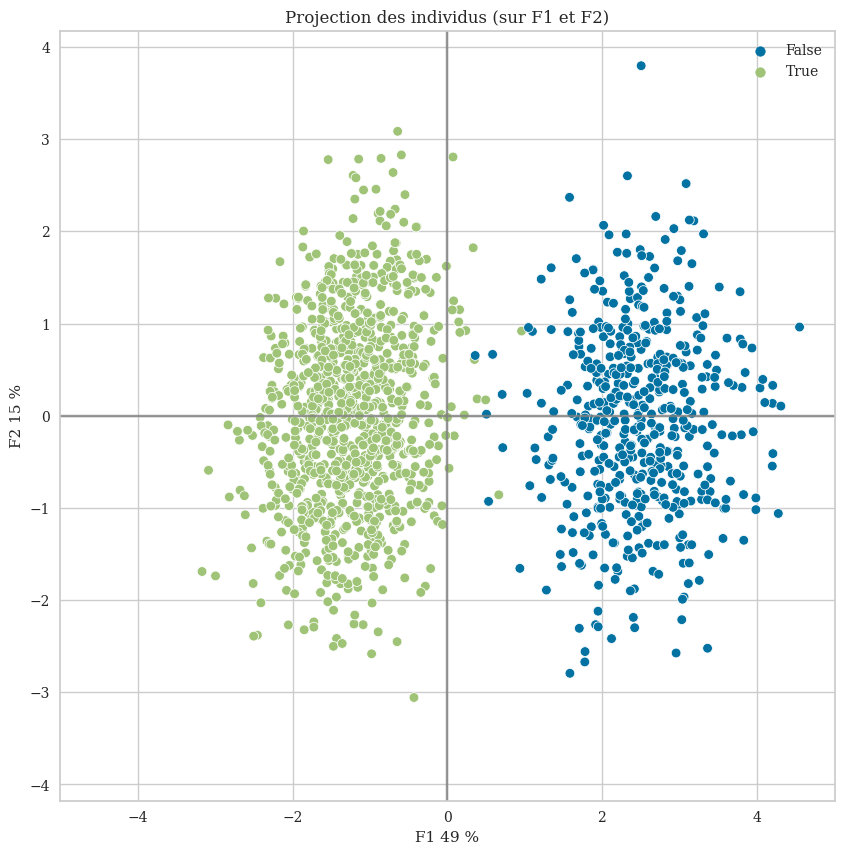

In [41]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,1),clusters=df['is_genuine'].tolist())

/tmp/ipykernel_150344/963579061.py:148: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


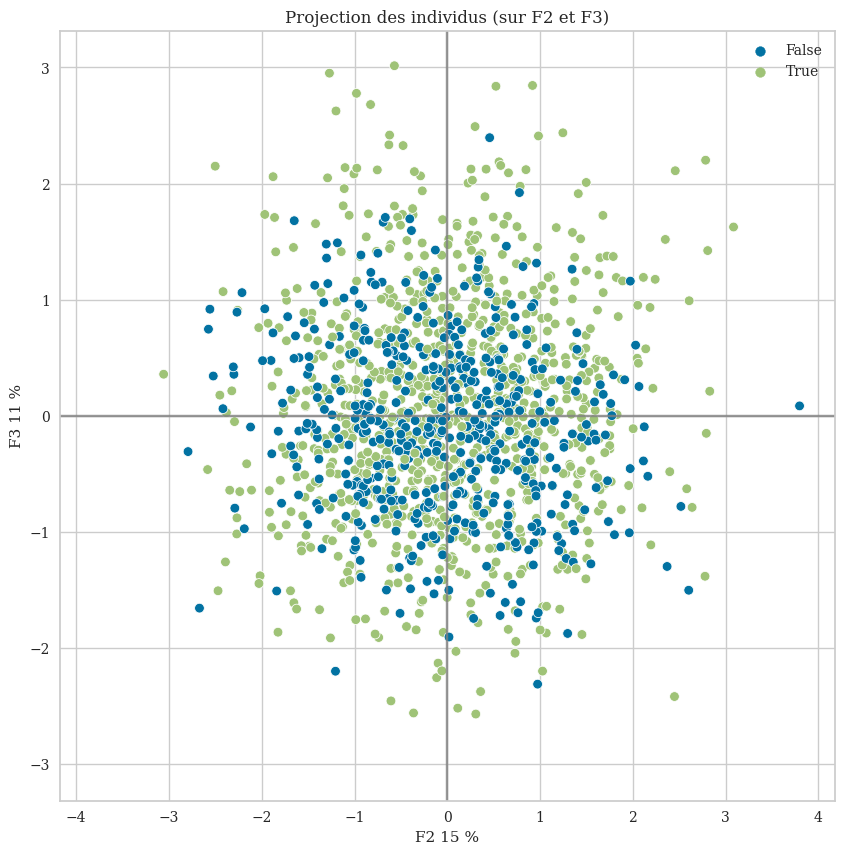

In [42]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,2),clusters=df['is_genuine'].tolist())

## CAH

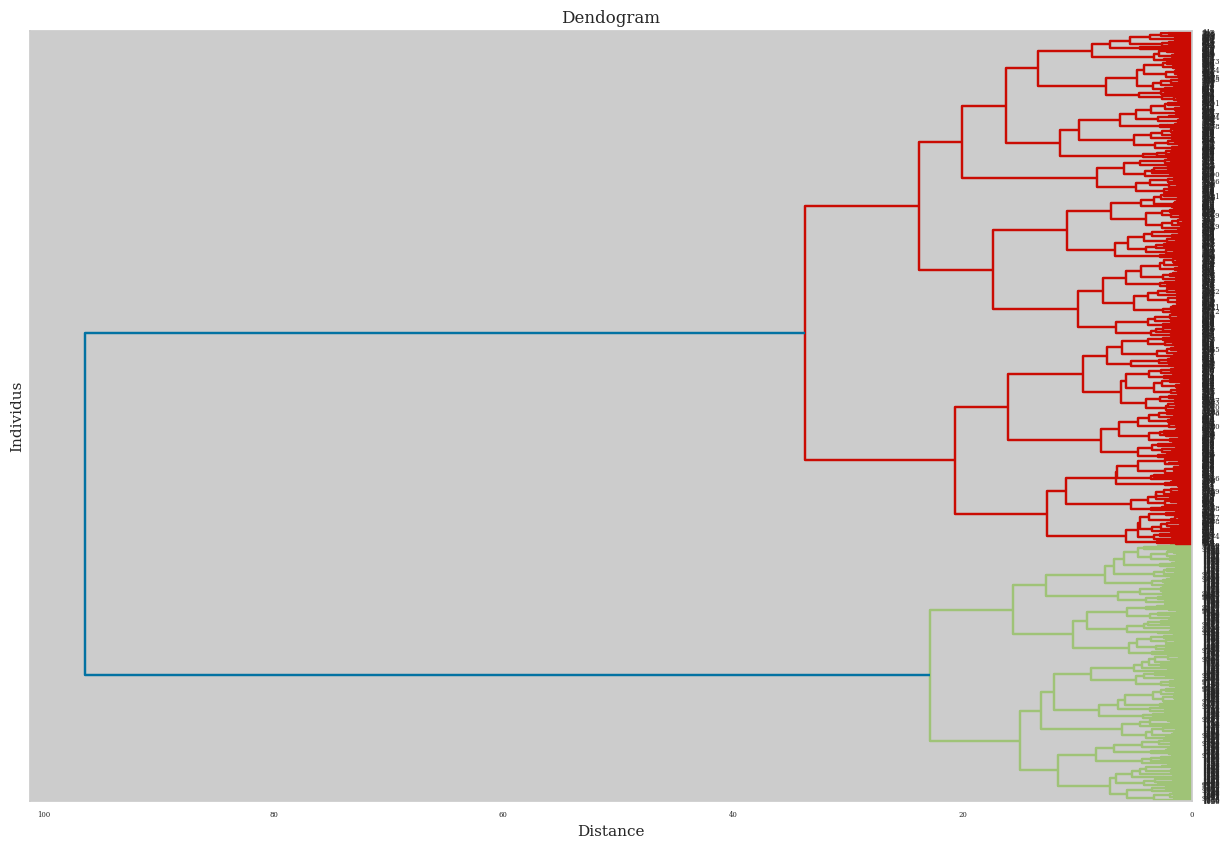

In [43]:
cah = CAH(df, df.columns)
cah.scale(StandardScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah.dendrogram(ax)

We can clearly distinguish between our two groups: 500 counterfeit bills and 1000 real bills.

# Kmeans

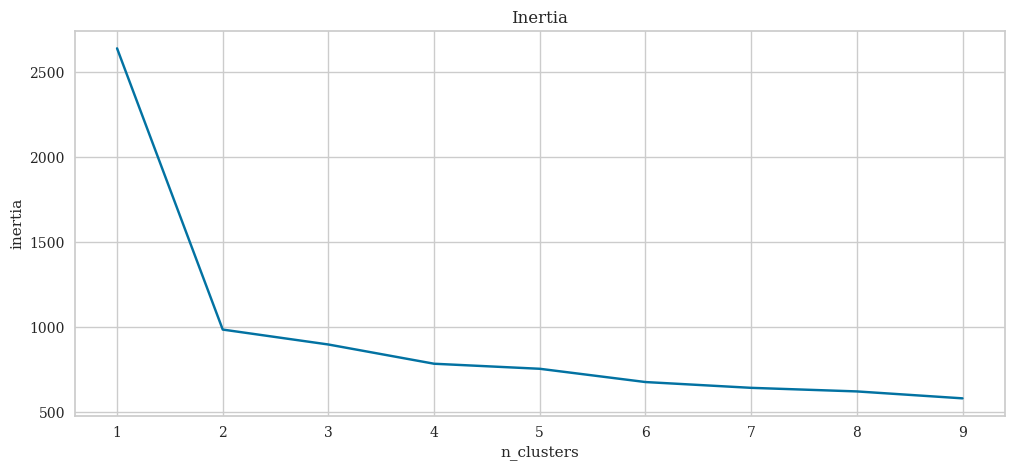

In [44]:
km = kmeans(df, df.columns)
fig, ax = plt.subplots(figsize=(12, 5))
km.plot_inertia(ax)


For n_clusters = 2, silhouette score is 0.557)
For n_clusters = 3, silhouette score is 0.245)
For n_clusters = 4, silhouette score is 0.173)
For n_clusters = 5, silhouette score is 0.223)


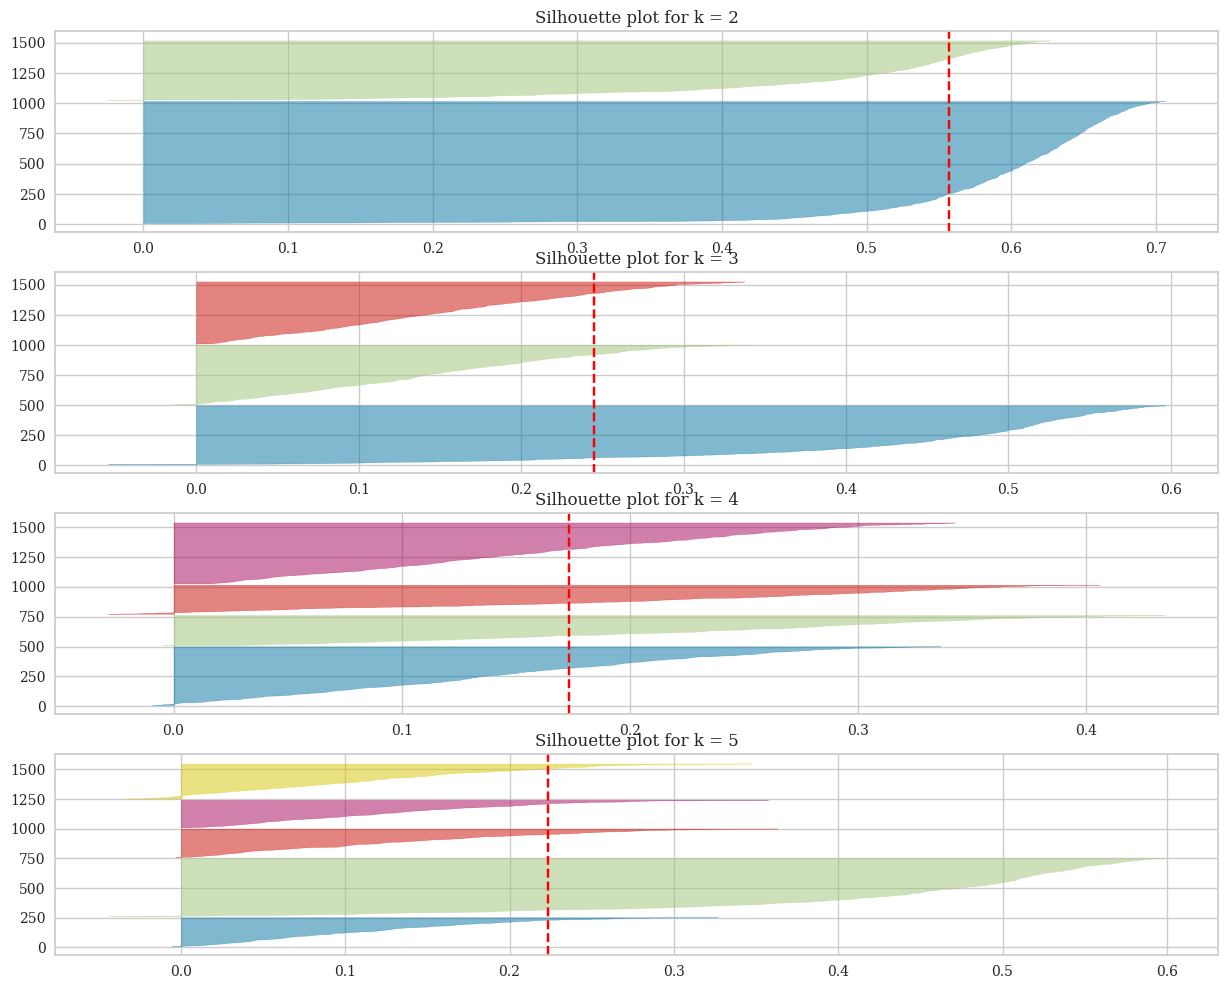

In [45]:
fig, ax = plt.subplots(4,1,figsize=(15, 12))
km.plot_silhouette(ax,[2,3,4,5])

Again, we can distinguish two groups with the knee method. The Silhouette method confirms this.

In [46]:
km.kmean_choose(2)
km.clusters

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [47]:
dfk = df.copy()
dfk['cluster']=km.clusters
dfk

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,True,171.81,104.86,104.95,4.520000,2.89,112.83,0
1,True,171.46,103.36,103.66,3.770000,2.99,113.09,0
2,True,172.69,104.48,103.50,4.400000,2.94,113.16,0
3,True,171.36,103.91,103.94,3.620000,3.01,113.51,0
4,True,171.73,104.28,103.46,4.040000,3.48,112.54,0
...,...,...,...,...,...,...,...,...
1495,False,172.17,104.49,103.76,5.033978,2.93,111.21,1
1496,False,172.08,104.15,104.17,4.785385,3.40,112.29,1
1497,False,171.72,104.46,104.12,5.716650,3.61,110.31,1
1498,False,172.66,104.33,104.41,5.191673,3.56,111.47,1


In [48]:
dfk[(dfk['is_genuine'] == True) & (dfk['cluster']== 1)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster


In [49]:
dfk[(dfk['is_genuine'] == False) & (dfk['cluster']== 0)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
995,False,171.52,104.05,104.31,4.24,3.70,112.60,0
996,False,172.17,104.20,104.13,3.86,3.38,112.44,0
1073,False,171.88,104.05,103.75,4.41,3.21,112.52,0
1091,False,172.09,104.15,104.17,4.15,3.40,113.85,0
1129,False,172.39,104.05,104.32,4.13,3.41,112.66,0
1158,False,171.45,104.21,104.18,4.55,3.52,113.21,0
1291,False,171.83,104.39,104.17,5.51,3.33,113.64,0
1372,False,172.02,103.99,104.28,4.22,2.98,112.42,0
1377,False,172.25,103.94,103.68,4.14,3.25,112.48,0


/tmp/ipykernel_150344/963579061.py:148: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())


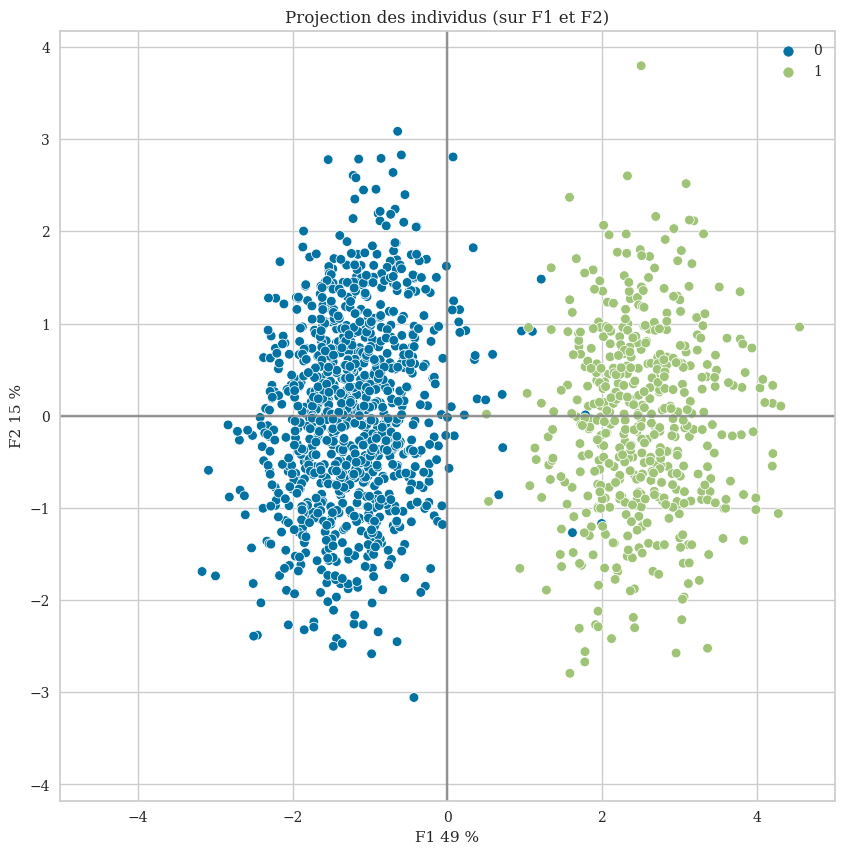

In [50]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

### Kmeans with prediction

#### Train Test Split

In [51]:
X = df.drop(['is_genuine'], axis=1)
y = df['is_genuine']
stratifier = df['is_genuine']

Test size: 0.1
Accuracy score: 0.9866666666666667
Confusion matrix:


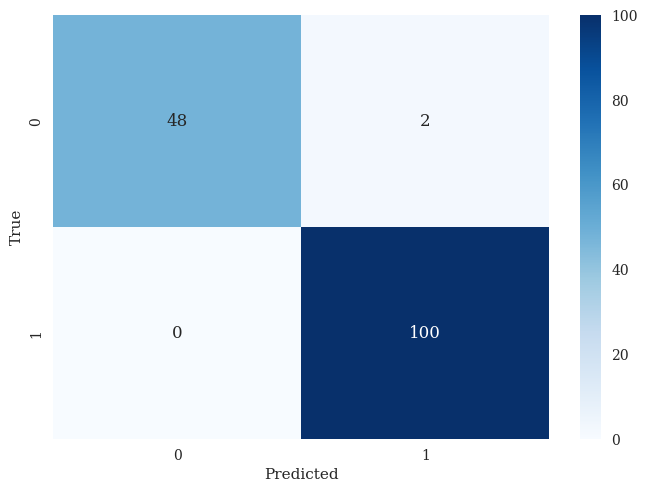


Test size: 0.2
Accuracy score: 0.9866666666666667
Confusion matrix:


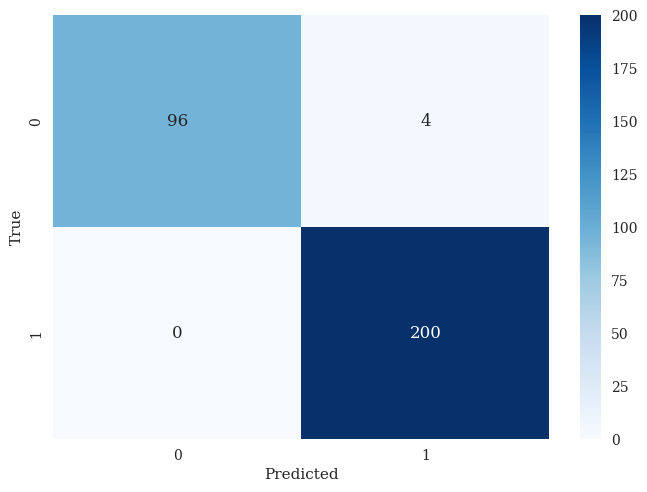


Test size: 0.3
Accuracy score: 0.011111111111111112
Confusion matrix:


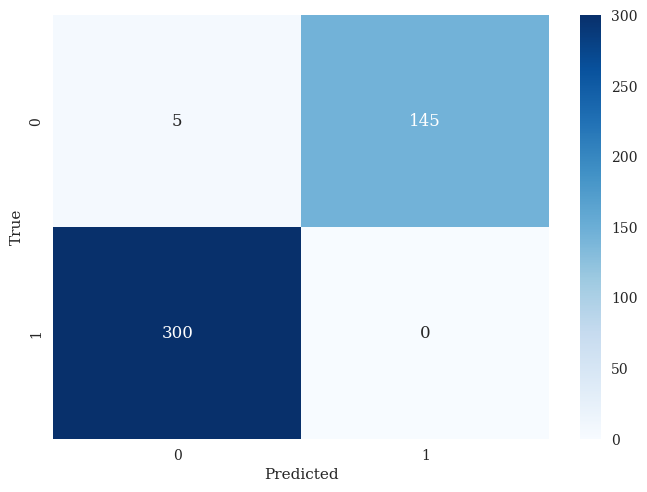


Test size: 0.4
Accuracy score: 0.9883333333333333
Confusion matrix:


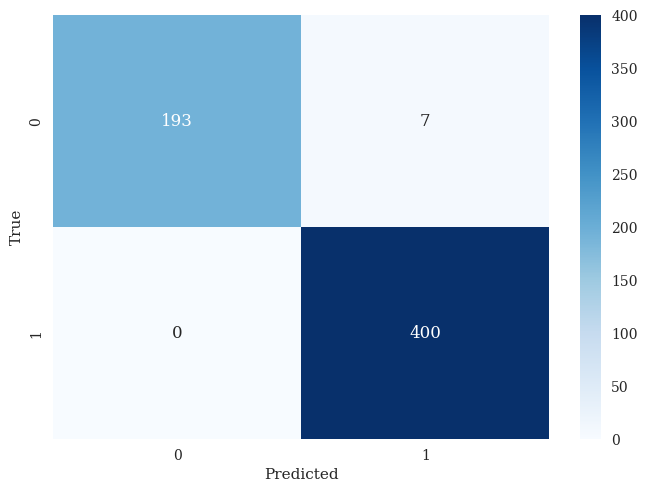


Test size: 0.5
Accuracy score: 0.010666666666666666
Confusion matrix:


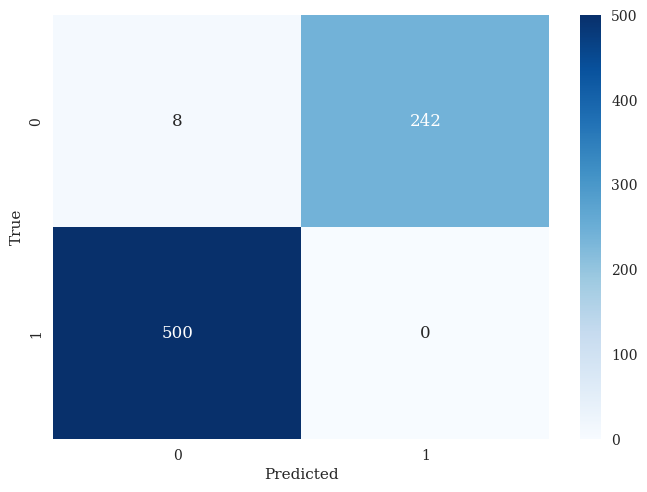


Test size: 0.6
Accuracy score: 0.9888888888888889
Confusion matrix:


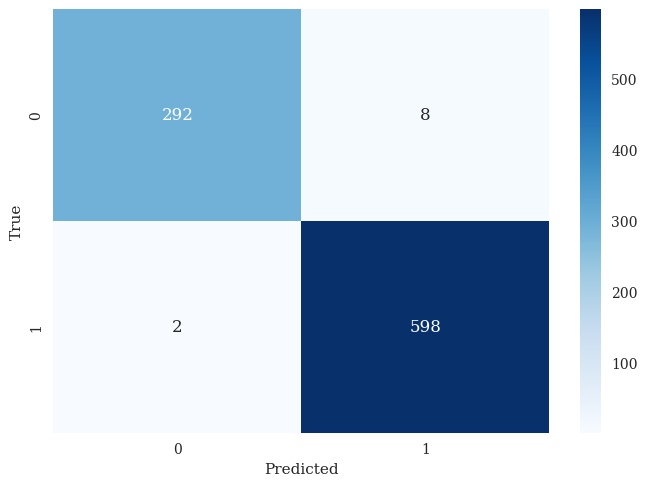


Test size: 0.7
Accuracy score: 0.010476190476190476
Confusion matrix:


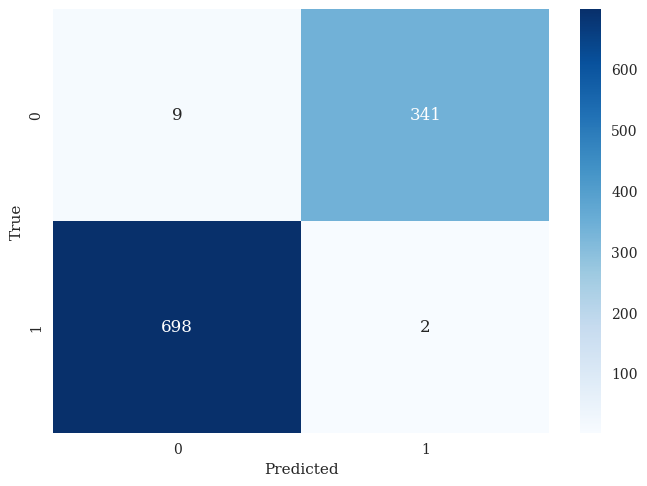


Test size: 0.8
Accuracy score: 0.015833333333333335
Confusion matrix:


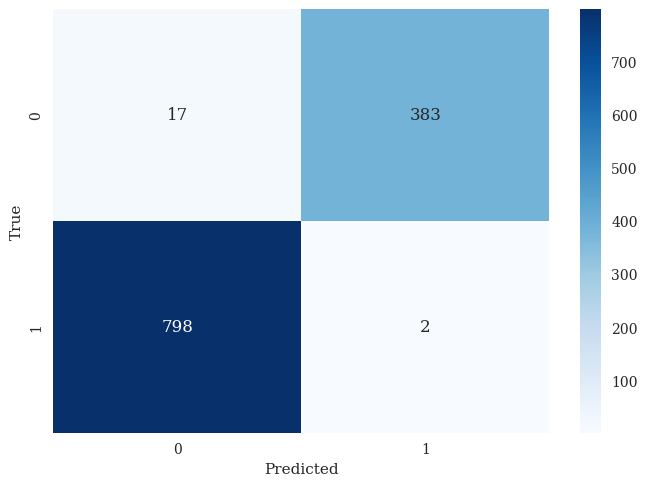


Test size: 0.9
Accuracy score: 0.017037037037037038
Confusion matrix:


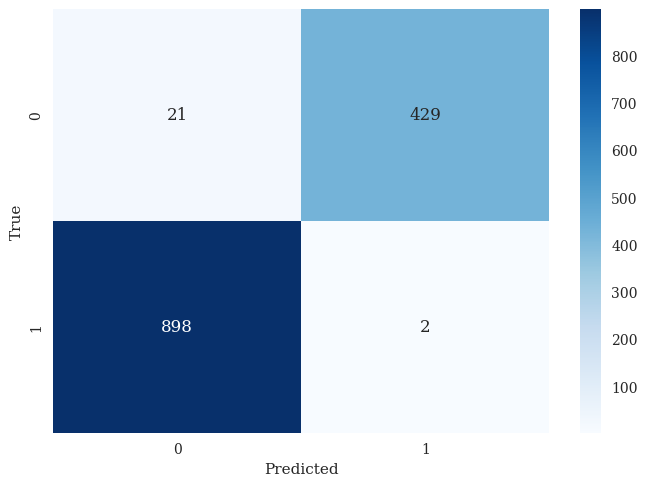

In [52]:
for i in range(1,10):
    print(color.BOLD + 'Test size: ' + str(i/10) + color.END)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i/10, stratify=stratifier, random_state=42)
    km.kmean_predict(2, 'is_genuine', X_train, X_test, y_train, y_test, random_state=42)
    print()

Since we have the best results with test_size = 0.6, we will keep this value.

Accuracy score: 0.9888888888888889
Confusion matrix:


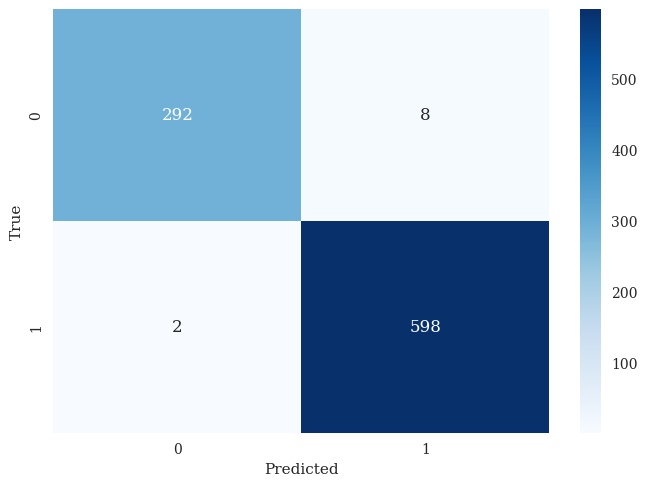

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, stratify=stratifier, random_state=42)
km.kmean_predict(2, 'is_genuine', X_train, X_test, y_train, y_test, random_state=42)



- True Positives (TP): 712 - This means there were 712 instances correctly predicted as the positive class.

- True Negatives (TN): 325 - This means there were 325 instances correctly predicted as the negative class.

- False Positives (FP): 10 - This means there were 10 instances predicted as the positive class, but they were actually of the negative class.

- False Negatives (FN): 3 - This means there were 3 instances predicted as the negative class, but they were actually of the positive class.

# Logistic Regression

In [54]:
def logisticreg(X_train,X_test, y_train, y_test, show_errors=False):
    logreg = LogisticRegression().fit(X_train, y_train)
    y_pred = logreg.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print()

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Create a heatmap using seaborn
    sns.set(font_scale=1.2)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_report)

    # Show False postives and False negatives
    if show_errors:
       X_pred = X_test.copy()
       X_pred['y_pred'] = y_pred 
       X_pred['y_test'] = y_test
       X_pred['false_positive'] = (X_pred['y_pred'] == 1) & (X_pred['y_test'] == 0)
       X_pred['false_negative'] = (X_pred['y_pred'] == 0) & (X_pred['y_test'] == 1)
    else:
        X_pred = X_test.copy()


    return logreg,X_pred

Accuracy: 0.9877777777777778



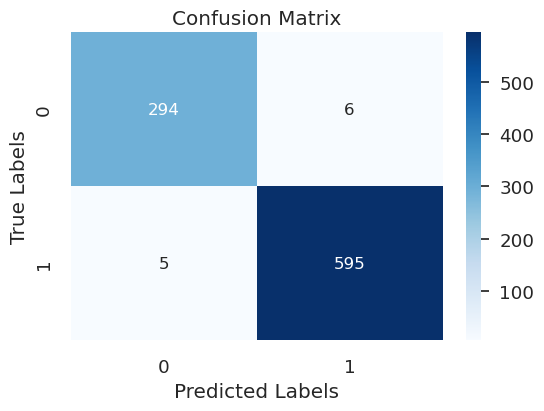

Classification Report:
               precision    recall  f1-score   support

       False       0.98      0.98      0.98       300
        True       0.99      0.99      0.99       600

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



(LogisticRegression(),
       diagonal  height_left  height_right  margin_low  margin_up  length  \
 1033    171.65       104.19        103.96        5.37       2.99  112.86   
 202     172.18       103.68        103.14        4.16       3.18  113.93   
 951     172.00       103.76        104.07        4.36       2.59  113.64   
 1077    172.12       104.18        104.31        5.36       3.31  111.43   
 977     171.63       104.05        104.25        4.61       3.10  110.91   
 ...        ...          ...           ...         ...        ...     ...   
 867     172.16       103.63        103.59        4.25       3.38  113.58   
 547     172.09       104.02        103.79        3.80       3.28  112.98   
 327     172.33       103.81        103.67        4.58       2.87  113.20   
 731     171.69       104.05        103.73        3.87       3.21  113.56   
 584     171.95       103.85        104.28        4.13       3.22  113.24   
 
       y_pred  y_test  false_positive  false_negati

In [55]:
logisticreg(X_train,X_test,y_train,y_test, show_errors=True)

Now we will test logistic regression results with a test_size of 0.7 to see if we can get better results.

In [56]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.7, stratify=stratifier, random_state=42)

Accuracy: 0.9904761904761905



/home/desktop/.conda/envs/pydata/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


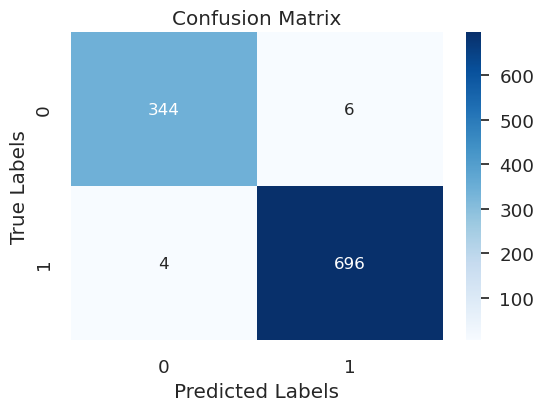

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99       350
        True       0.99      0.99      0.99       700

    accuracy                           0.99      1050
   macro avg       0.99      0.99      0.99      1050
weighted avg       0.99      0.99      0.99      1050



(LogisticRegression(),
       diagonal  height_left  height_right  margin_low  margin_up  length
 1344    172.15       104.23        104.41        5.47       3.37  112.53
 1314    171.53       104.03        104.05        5.77       3.22  111.93
 241     171.94       103.91        103.99        4.02       2.94  113.06
 454     171.55       103.50        104.51        4.61       2.95  113.31
 340     171.87       103.77        104.23        4.10       3.08  112.44
 ...        ...          ...           ...         ...        ...     ...
 315     171.75       104.13        103.91        4.24       2.97  113.33
 892     171.99       103.62        103.42        3.48       3.37  112.94
 132     172.27       104.12        103.96        4.12       2.74  113.12
 1008    172.09       104.24        103.83        5.10       3.37  111.69
 843     171.67       103.76        103.59        3.82       3.17  112.77
 
 [1050 rows x 6 columns])

In [57]:
logisticreg(X_train2,X_test2,y_train2,y_test2,show_errors=False)

We can see that we have better results with a test_size of 0.7.

- True Positives (TP): 696 - This means there were 692 instances correctly predicted as the positive class.

- True Negatives (TN): 344 - This means there were 334 instances correctly predicted as the negative class.

- False Positives (FP): 6 - This means there were 16 instances predicted as the positive class, but they were actually of the negative class.

- False Negatives (FN): 4 - This means there were 8 instances predicted as the negative class, but they were actually of the positive class.

Accuracy: 0.9904761904761905



/home/desktop/.conda/envs/pydata/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


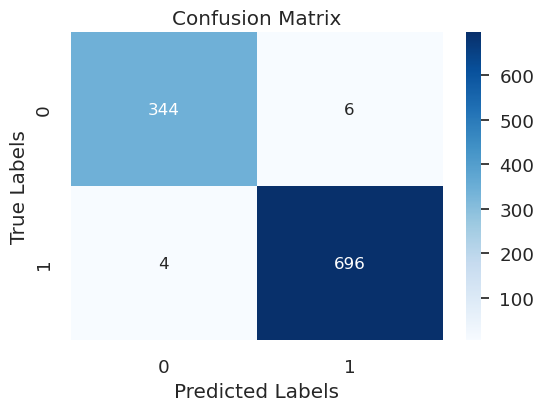

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.98      0.99       350
        True       0.99      0.99      0.99       700

    accuracy                           0.99      1050
   macro avg       0.99      0.99      0.99      1050
weighted avg       0.99      0.99      0.99      1050



In [61]:
logreg,x = logisticreg(X_train2,X_test2,y_train2,y_test2,show_errors=True)

## Check of the false positive and false negative

In [62]:
x['False'] = x['false_positive'] | x['false_negative']
x[(x['false_positive'] == True) | (x['false_negative'] == True)]


,diagonal,height_left,height_right,margin_low,margin_up,length,y_pred,y_test,false_positive,false_negative,False
1158,171.45,104.21,104.18,4.550000,3.52,113.21,True,False,True,False,True
654,172.14,104.34,104.20,4.630000,3.02,112.47,False,True,False,True,True
1129,172.39,104.05,104.32,4.130000,3.41,112.66,True,False,True,False,True
1467,171.83,104.14,104.06,4.648929,3.02,112.36,False,True,False,True,True
0,171.81,104.86,104.95,4.520000,2.89,112.83,False,True,False,True,True
1415,171.93,104.15,103.98,4.570000,3.57,112.71,True,False,True,False,True
711,171.94,104.11,104.16,4.080000,3.35,111.76,False,True,False,True,True
1372,172.02,103.99,104.28,4.220000,2.98,112.42,True,False,True,False,True
1091,172.09,104.15,104.17,4.150000,3.40,113.85,True,False,True,False,True
1073,171.88,104.05,103.75,4.410000,3.21,112.52,True,False,True,False,True


In [63]:
x[x['margin_low'].isin(y_pred_linear_reg) & (x['False'] == True)]

,diagonal,height_left,height_right,margin_low,margin_up,length,y_pred,y_test,false_positive,false_negative,False
1467,171.83,104.14,104.06,4.648929,3.02,112.36,False,True,False,True,True


One of our predicted values is leading to a false negative. Since there's only one value involved, we can't draw the conclusion that bad predictions are due to values predicted on margin_low.

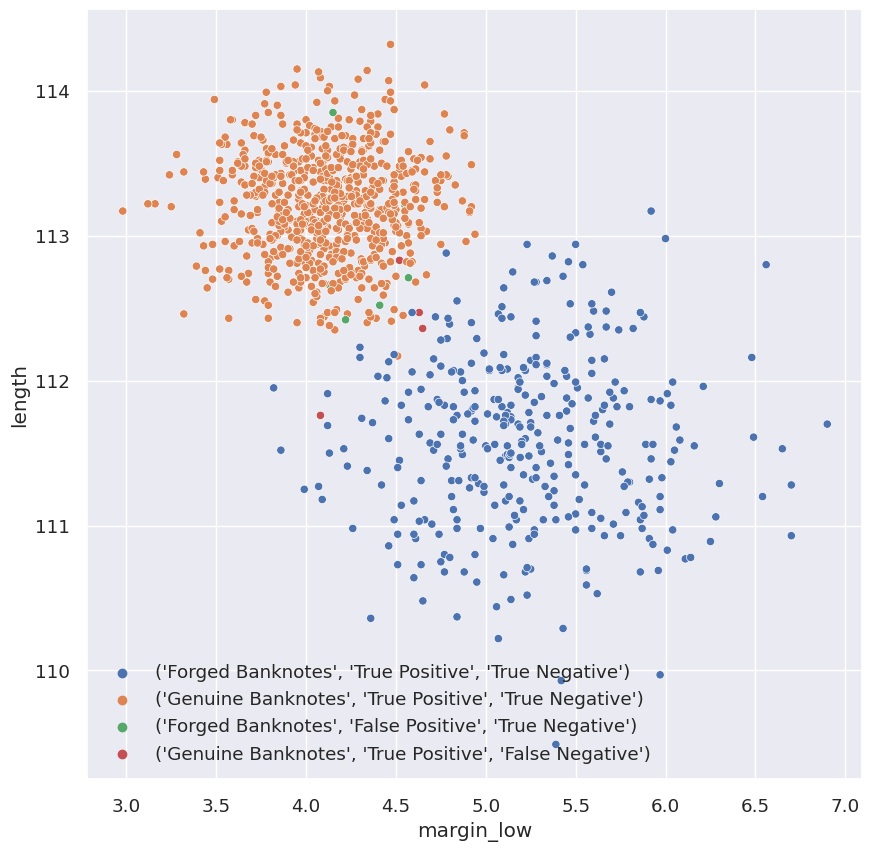

In [64]:
fig, ax = plt.subplots(figsize=(10, 10))
banknotes = {True: "Genuine Banknotes", False: "Forged Banknotes"}
fp = {True: "False Positive", False: "True Positive"}
fn = {True: "False Negative", False: "True Negative"}
x['y_test'] = x['y_test'].map(banknotes)
x['false_positive'] = x['false_positive'].map(fp)
x['false_negative'] = x['false_negative'].map(fn)
g=sns.scatterplot(data=
                x[['margin_low','length']], 
                x="margin_low", 
                y="length", 
                hue=x[['y_test','false_positive','false_negative']].apply(tuple,axis=1),
                ax=ax)
new_labels = ['Forged Banknotes','Genuine Banknotes', 'False positives', 'False negatives']

#plt.legend(labels=['True','False positive','False negative'])

Most false positives and false negatives are found on the borderline between genuine and counterfeit bills. To get rid of these, we could add more feature to our dataset, like spectral analysis results for example.

# Export of the model

In [66]:
import pickle
# export logreq model
filename = 'logreg_model.pkl'
pickle.dump(logreg, open(filename, 'wb'))